In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [37]:
def set_seed():
    np.random.seed(20030427)

In [38]:
def simulate_GBM(T,n_steps,X0,sigma):
    """
    Generate Efficient Price Using GBM (BS)

    Parameters:
    T: Time Horizon
    n_steps: Number of time steps
    X0: Initial price
    sigma: Volatility

    Returns:
    t (numpy.ndarray): Array of time points.
    X (numpy.ndarray): Simulated price path following GBM.
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    log_X = np.log(X0) - 0.5 * sigma**2 * t + sigma * np.cumsum(dW)
    X = np.exp(log_X)

    return t, X

In [39]:
def simulate_observed_price(X, alpha, eta1,eta2, L=1):
    """
    Simulate observed price

    Parameters:
    X : The efficient price series.
    alpha : The minimum price tick size.
    eta : A noise parameter affecting price adjustment.
    L : The price adjustment factor, default is 1.

    Returns:
    X : The original efficient price series.
    P : The observed price series with discrete adjustments.
    change_indices : Indices where observed prices change.
    """

    P = np.zeros_like(X) # Initialize observed price array
    P[0] = np.round(X[0] / alpha) * alpha  # Round initial price to the nearest tick size
    change_indices = [0] # Store indices where price changes occur

    # Compare efficient price with thresholds and adjust observed price accordingly
    for i in range(1, len(X)):
    
        upper_threshold = P[i-1] + alpha * (L - 0.5 + eta1)
        lower_threshold = P[i-1] - alpha * (L - 0.5 + eta2)
        
        if X[i] >= upper_threshold:
            P[i] = P[i-1] + L * alpha
            change_indices.append(i)
        elif X[i] <= lower_threshold:
            P[i] = P[i-1] - L * alpha
            change_indices.append(i)
        else:
            P[i] = P[i-1]
    
    return  X, P, change_indices

In [40]:
def plot_uncertainty_zone_matplotlib(X,alpha, eta1,eta2):
    set_seed()
    X, P, change_indices = simulate_observed_price(X,alpha,eta1,eta2)
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot Efficient Price and Observed Price
    ax.plot(t, X, label="Efficient Price", color="blue", linewidth=1.5)
    ax.step(t, P, where="post", label="Observed Price", color="red", linestyle="--", linewidth=1.5)

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(len(X)):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * (eta2)
        upper_bounds[i] = mid_prices[i] + alpha * (eta1)

    # Add grid lines at mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)
    all_lower_bounds = np.unique(lower_bounds)
    all_upper_bounds = np.unique(upper_bounds)

    # Horizontal grid lines
    for level in all_mid_prices:
        ax.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=1)
    for level in all_lower_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=1)
    for level in all_upper_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=1)

    # Add shaded area for uncertainty zones
    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]

    # Fill shaded area **evenly**
    #ax.fill_between(t, shaded_lower, shaded_upper, color="gray", alpha=0.2)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta2
        upper = mid_price + alpha * eta1+alpha

        ax.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Price", fontsize=14)
    ax.set_title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    ax.legend(fontsize=12)
    plt.savefig("UncertaintyZone.pdf",format = "pdf")

    # Show plot
    plt.show()

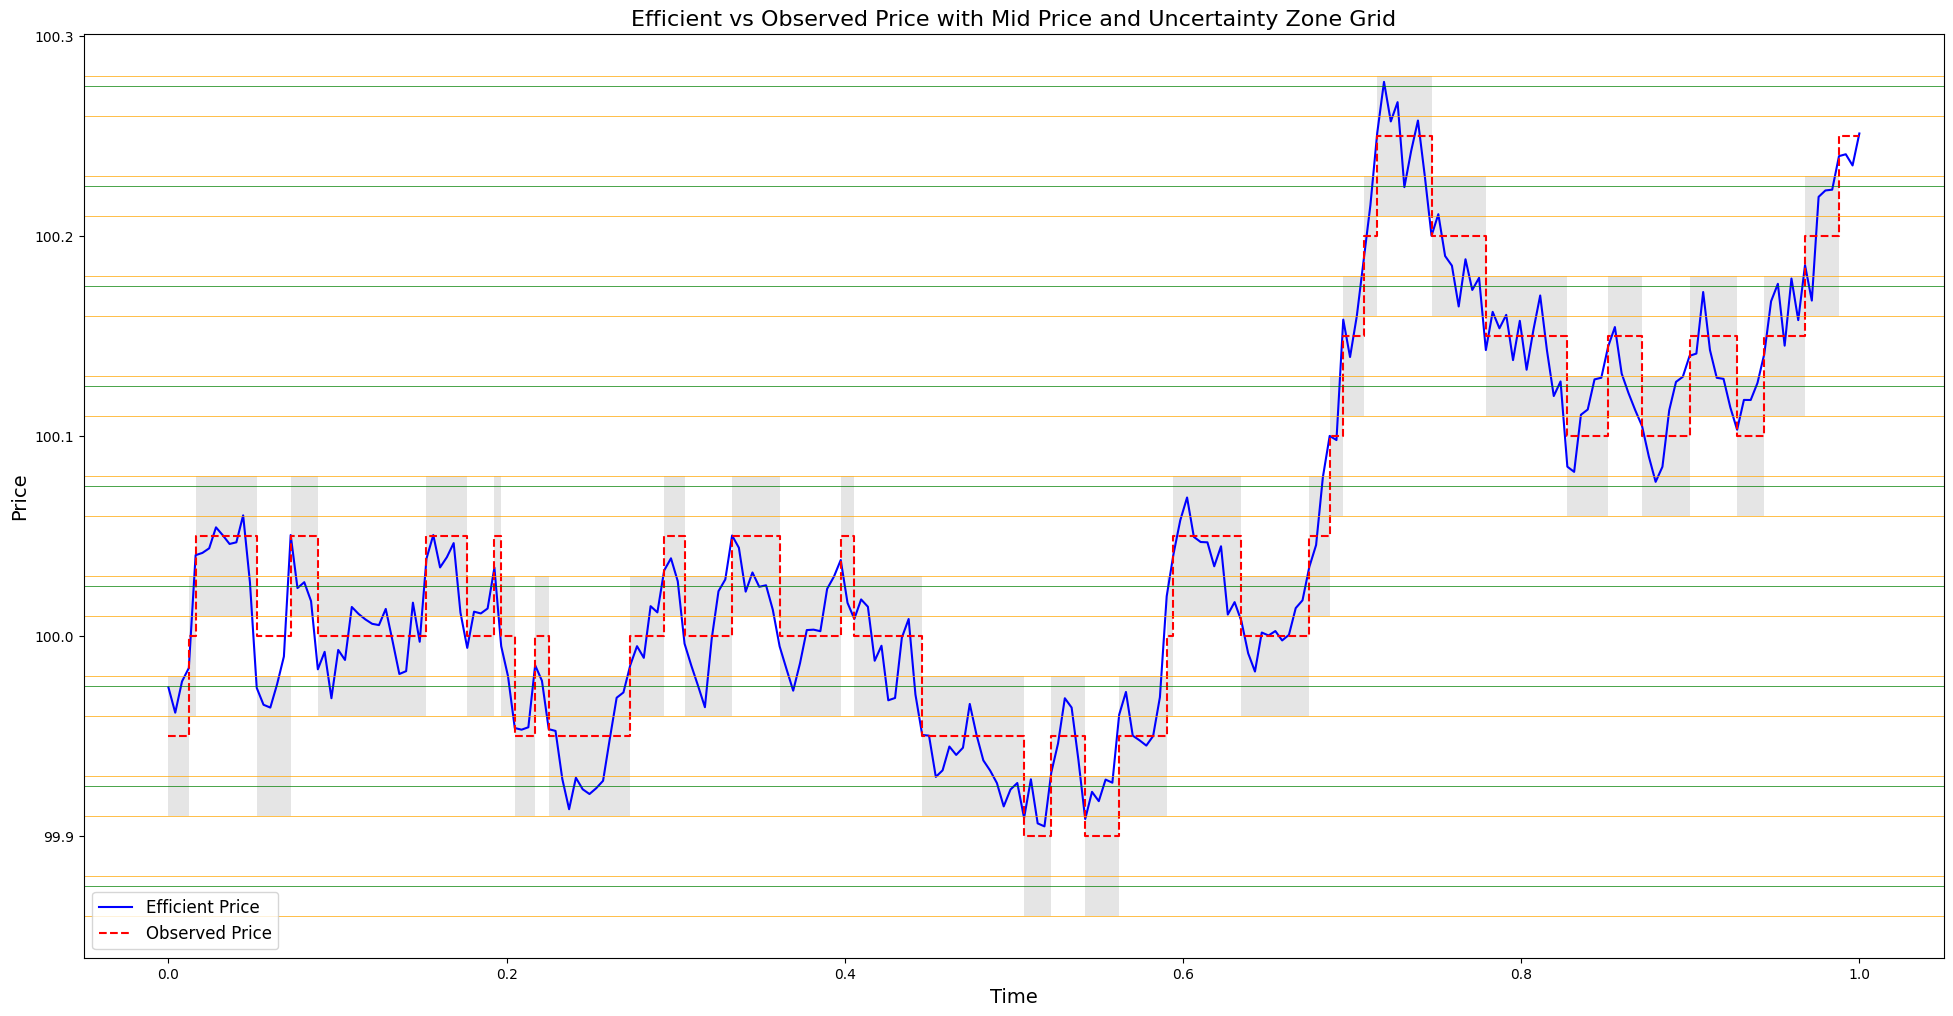

In [41]:
alpha = 0.05      # Tick size
eta1 = 0.1       # Uncertainty zone width
eta2 = 0.3
T = 1.0          # Time horizon
sigma = 0.05/np.sqrt(252)   # Volatility, sigma=0.01  5/np.sqrt(252)
X0 = 100.0       # Initial price
n_steps = 250   # Number of time steps
K = 100 # Strike
number_of_paths = 1000 # For Monto Carlo
t, X = simulate_GBM(T, n_steps, X0, sigma)
plot_uncertainty_zone_matplotlib(X,alpha,eta1,eta2)

In [42]:
eta1 = 0.4  # Uncertainty zone width
eta2 = 0.1
sigma = 0.01
n_steps = 500

In [43]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the Black-Scholes price and delta of a European call option.

    Parameters:
    S : Current stock price (underlying asset price).
    K : Strike price of the option.
    T : Time to maturity (in years).
    r : Risk-free interest rate (continuous compounding).
    sigma : Volatility of the underlying asset.

    Returns:
    call_price : The theoretical price of the European call option.
    delta : The delta of the call option.
    """
    if sigma < 0 or T < 0:
        raise ValueError("sigma and T must be greater than zero")
    d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)  
    return call_price, delta

In [44]:
def get_optimal_tau(X, alpha, eta1,eta2):

    """
    Computes the optimal sampling times (tau) based on the efficient price X,
    adjusting when the price crosses the uncertainty zone.

    Parameters:
    X : The efficient price series.
    alpha : The minimum price tick size.
    eta : A noise parameter affecting price adjustments.

    Returns:
    tau : Indices where price updates occur.
    """

    tau = [0]  # Initialize the list of sampling times with the first index
    l = int(round(alpha**(-0.5)))  # Compute the step adjustment factor (rounded integer)
    current_zone = (X[0] // alpha) * alpha  # Determine the starting price zone
    upper_threshold = alpha * (l - 0.5 + eta1) # Compute the uncertainty threshold
    lower_threshold = alpha * (l - 0.5 + eta2)
    
    for i in range(1, len(X)):
        upper = current_zone + upper_threshold # Upper boundary of the uncertainty zone
        lower = current_zone - lower_threshold # Lower boundary of the uncertainty zone
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha # Reset the zone to the new price level
    return tau

In [45]:
def calculate_hedging_error(t, X, P, tau, K, sigma,use_efficient_price=True):

    """
    Computes the hedging error by simulating a dynamic hedging strategy based on the Black-Scholes model.

    Parameters:
    t : Time vector.
    X : Efficient price series.
    P : Observed price series.
    tau : Optimal sampling times (indices where rebalancing occurs).
    K : Strike price of the option.
    sigma : Volatility of the underlying asset.
    use_efficient_price : Whether to use the efficient price (X) or observed price (P) for hedging calculations.

    Returns:
    The final hedging error, calculated as the difference between the call option value and the portfolio value at maturity.
    """

    T_total = t[-1] # Total time horizon
    portfolio = np.zeros(len(tau)) # Initialize portfolio values
    positions = np.zeros(len(tau)) # Store delta hedging positions
    calls = np.zeros(len(tau))  # Store Black-Scholes call option prices
    
    # Initialize portfolio and hedging position based on the initial Black-Scholes call price
    portfolio[0], positions[0] = black_scholes_call(X[tau[0]], K, T - t[tau[0]],0,sigma)
    calls[0] = portfolio[0]
    
   
    for j in range(1, len(tau)):
        if use_efficient_price:
            price_change = X[tau[j]] - X[tau[j-1]]
        else:
            price_change = P[tau[j]] - P[tau[j-1]]
        
        # Update portfolio value based on hedging position
        portfolio[j] = portfolio[j-1] + positions[j-1] * price_change
        
        # Compute remaining time to maturity
        remaining_T = T_total - t[tau[j]]
        
        # Compute updated Black-Scholes call price and delta
        calls[j], positions[j] = black_scholes_call(X[tau[j]], K, remaining_T,0,sigma)
    
    plt.plot(t[tau], portfolio, label = 'Portfolio value at stopping time')
    plt.plot(t[tau], calls, label = 'Call option price at stopping time')

    # Return the final hedging error (difference between call price and portfolio value)
    return calls[-1]-portfolio[-1]

In [46]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

In [47]:
def generate_observed_prices(X, tau, alpha):

    """
    Generates observed prices based on the exit times (tau), ensuring price updates 
    occur only at specific time steps.

    Parameters:
    X : The efficient price series.
    tau : Indices of exit times where price updates occur.
    alpha : Minimum price tick size.

    Returns:
    P : The observed price series.
    """

    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.round(X[i] / alpha) * alpha # Round price to nearest tick size
        P[i] = current_p if current_p is not None else X[0] # Use the last observed price
    return P

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_92458/871431706.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


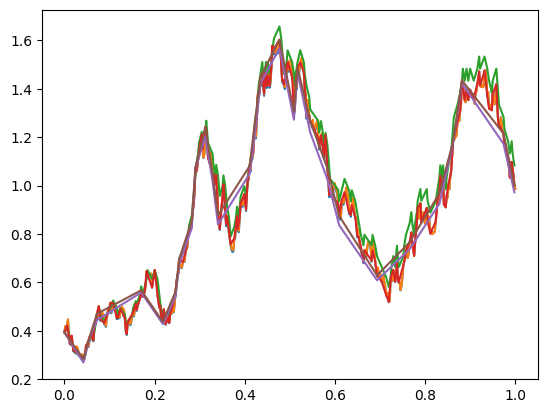

In [48]:
error = np.zeros(1)
for i in range(1):
        t, X = simulate_GBM(T, n_steps, X0, sigma)
        _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta1,eta2,1)

        tau_optimal = get_optimal_tau(X, alpha, eta1,eta2)

        tau_ideal = list(range(len(t)))  # All time points

        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        
        error_1[i] = calculate_hedging_error(t, X, X,tau_ideal, K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma,False)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False)

Processing Paths:   0%|          | 4/1000 [00:00<01:44,  9.53it/s]/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_92458/871431706.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
Processing Paths: 100%|██████████| 1000/1000 [01:20<00:00, 12.46it/s]


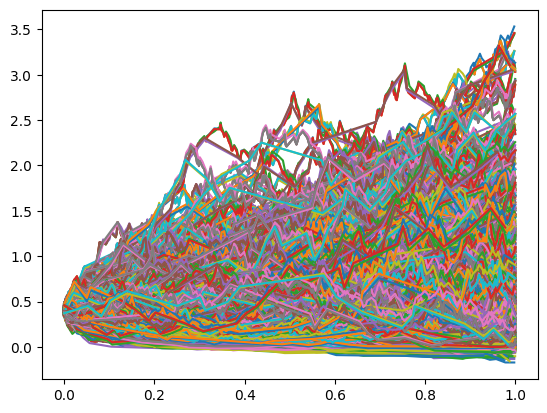

In [49]:
from tqdm import tqdm
len2 = []
len3 = []
for i in tqdm(range(number_of_paths), desc="Processing Paths"):
        t, X = simulate_GBM(T, n_steps, X0, sigma)
        _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta1,eta2)
        len2.append(len(tau_fixed))
        tau_optimal = get_optimal_tau(X, alpha, eta1,eta2)
        tau_ideal = list(range(len(t)))
        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        len3.append(len(tau_optimal))
        error_1[i] = calculate_hedging_error(t, X, X,tau_fixed, K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma, False)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma, False)

In [50]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())

-6.865429452329719e-05
-0.13417546612931677
0.008165249244545718
0.01776356623623385
0.054992229207693685
0.042369103416503115


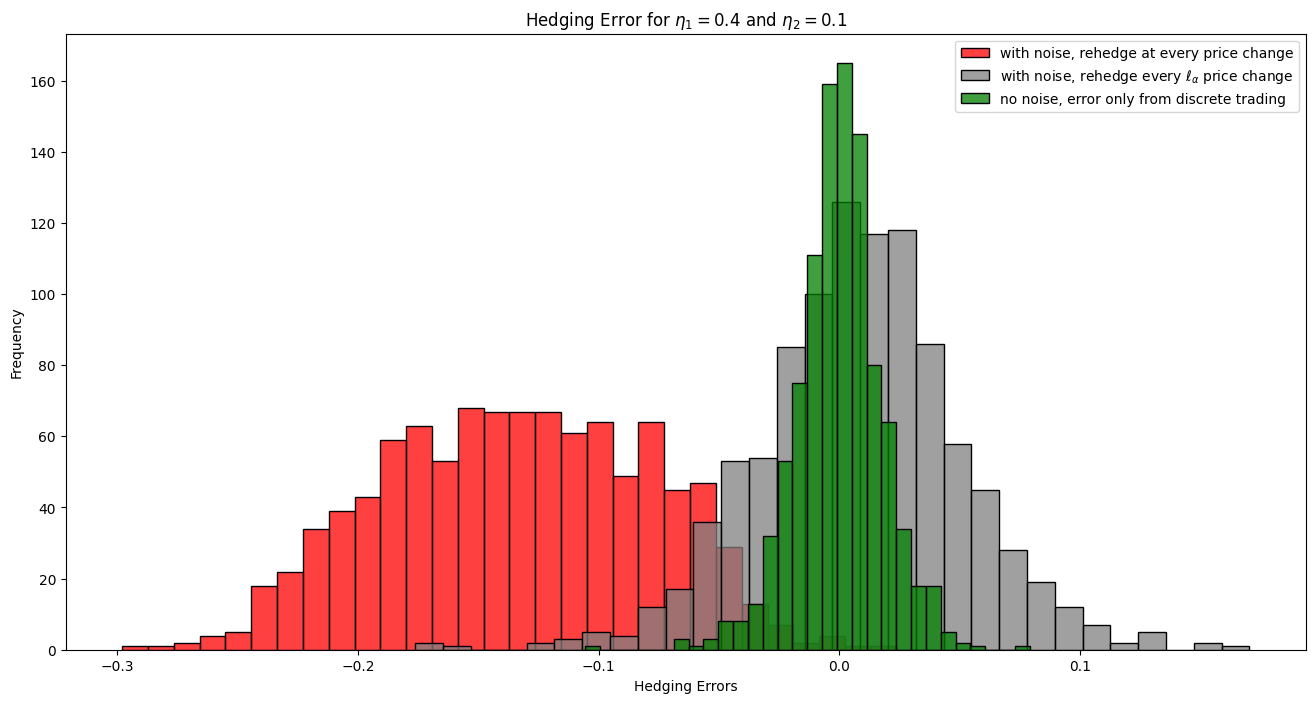

In [53]:
plt.figure(figsize=(16, 8))
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 30, color = 'red',stat = 'count',legend=True)
sns.histplot(error_3, label = r"with noise, rehedge every $\ell_\alpha$ price change", bins = 30, color='grey',stat = 'count',legend=True)
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 30, color = 'green',stat = 'count',legend=True)

plt.xlabel("Hedging Errors")
plt.ylabel("Frequency")
plt.title(r"Hedging Error for $\eta_1 = 0.4$ and $\eta_2 = 0.1$")
plt.legend()
plt.savefig("hedgingError_two_eta.pdf", format = "pdf")

In [52]:
print(f"{np.mean(len2):.2f}")
print(f"{np.std(len2):.2f}")
print(f"{np.mean(len3):.2f}")
print(f"{np.std(len3):.2f}")

232.24
11.79
22.86
3.87
